In [1]:
#import
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import cv2
from IPython.display import clear_output
import pickle
from sklearn.neighbors import KNeighborsClassifier

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [3]:
#simple method
def simple_classification(hand_landmarks):
    finger_up = [False, False, False, False, False]
    
    if(hand_landmarks.landmark[4].y < hand_landmarks.landmark[3].y
       and hand_landmarks.landmark[3].y < hand_landmarks.landmark[2].y
       and hand_landmarks.landmark[2].y < hand_landmarks.landmark[1].y
       and hand_landmarks.landmark[1].y < hand_landmarks.landmark[0].y
       and hand_landmarks.landmark[3].y < hand_landmarks.landmark[6].y 
      ):
        finger_up[0] = True
    if(hand_landmarks.landmark[8].y < hand_landmarks.landmark[7].y
       and hand_landmarks.landmark[7].y < hand_landmarks.landmark[6].y
       and hand_landmarks.landmark[6].y < hand_landmarks.landmark[5].y
       and hand_landmarks.landmark[5].y < hand_landmarks.landmark[0].y
      ):
        finger_up[1] = True
    if(hand_landmarks.landmark[12].y < hand_landmarks.landmark[11].y
       and hand_landmarks.landmark[11].y < hand_landmarks.landmark[10].y
       and hand_landmarks.landmark[10].y < hand_landmarks.landmark[9].y
       and hand_landmarks.landmark[9].y < hand_landmarks.landmark[0].y\
      ):
        finger_up[2] = True
    if(hand_landmarks.landmark[16].y < hand_landmarks.landmark[15].y
       and hand_landmarks.landmark[15].y < hand_landmarks.landmark[14].y
       and hand_landmarks.landmark[14].y < hand_landmarks.landmark[13].y
       and hand_landmarks.landmark[13].y < hand_landmarks.landmark[0].y
      ):
        finger_up[3] = True
    if(hand_landmarks.landmark[20].y < hand_landmarks.landmark[19].y 
       and hand_landmarks.landmark[19].y < hand_landmarks.landmark[18].y 
       and hand_landmarks.landmark[18].y < hand_landmarks.landmark[17].y
       and hand_landmarks.landmark[17].y < hand_landmarks.landmark[0].y
      ):
        finger_up[4] = True
    
    #print(finger_up)
    
    if(finger_up[1] and not finger_up[2] and not finger_up[3] and not finger_up[4]):
        return 0
    elif(finger_up[1] and finger_up[2] and not finger_up[3] and not finger_up[4]):
        return 1
    elif(finger_up[1] and finger_up[2] and finger_up[3] and not finger_up[4]):
        return 2
    elif(finger_up[0] and not finger_up[1] and not finger_up[2] and not finger_up[3] and not finger_up[4]):
        return 3
    else:
        return 4

In [4]:
with open("main_data.pkl" , "rb") as f:
    training_dataset = pickle.load(f)
with open("test_data.pkl" , "rb") as f:
    test_dataset = pickle.load(f)

In [5]:
print(len(training_dataset), len(test_dataset))

400 100


In [6]:
correct_cnt = 0
total_cnt = 0
for data in test_dataset:
    hand_landmarks, true_class = data
    predict_class = simple_classification(hand_landmarks)
    if (predict_class == true_class):
        correct_cnt +=1
    total_cnt+=1
print(f"accuracy : {correct_cnt * 100/total_cnt} %")

accuracy : 91.0 %


[[20.  0.  0.  0.  0.]
 [ 0. 20.  0.  0.  0.]
 [ 0.  0. 20.  0.  0.]
 [ 0.  0.  0. 11.  9.]
 [ 0.  0.  0.  0. 20.]]


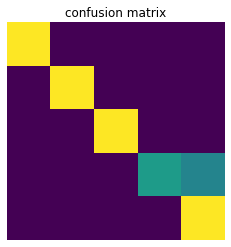

In [8]:
# confusion matrix
confusion_matrix = np.zeros((5,5))
for data in test_dataset:
    hand_landmarks, true_class = data
    predict_class = simple_classification(hand_landmarks)
    confusion_matrix[true_class, predict_class] +=1
print(confusion_matrix)

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)
ax.set_title("confusion matrix")
plt.axis("off")
plt.savefig("simple_confusion.png")
plt.show()

In [10]:
#complex method
classifier = KNeighborsClassifier(n_neighbors=3)

In [11]:
new_dataset = []
for data in training_dataset:
    hand_landmarks, true_class = data

    adjacency_list = [
        [0,1,2],[1,2,3],[2,3,4],[0,5,6],[5,6,7],[6,7,8],
        [0,9,10],[9,10,11],[10,11,12],[0,13,14],[13,14,15],
        [14,15,16],[0,17,18],[17,18,19],[18,19,20]
    ]

    angle_list=[]

    for adjacency in adjacency_list :
        idx0, idx1, idx2 = adjacency
        point0 = np.array([hand_landmarks.landmark[idx0].x, hand_landmarks.landmark[idx0].y, hand_landmarks.landmark[idx0].z])
        point1 = np.array([hand_landmarks.landmark[idx1].x, hand_landmarks.landmark[idx1].y, hand_landmarks.landmark[idx1].z])
        point2 = np.array([hand_landmarks.landmark[idx2].x, hand_landmarks.landmark[idx2].y, hand_landmarks.landmark[idx2].z])

        vector0 = point0 - point1
        vector1 = point2 - point1
        inner_product_result = np.dot(vector0,vector1)
        cos_theta = inner_product_result/(np.linalg.norm(vector0) * np.linalg.norm(vector1))
        theta = np.arccos(cos_theta)
        angle_list.append(theta)
    
    new_dataset.append([angle_list, true_class])


In [12]:
with open("new_training_dataset.pkl" , "wb") as f:
    pickle.dump(new_dataset, f)

In [13]:
training_inputs = []
training_labels = []
for data in new_dataset:
    angle_list, true_class = data
    training_inputs.append(angle_list)
    training_labels.append(true_class)
classifier.fit(training_inputs, training_labels)

KNeighborsClassifier(n_neighbors=3)

In [14]:
new_test_dataset = []
for data in test_dataset:
    hand_landmarks, true_class = data

    adjacency_list = [
        [0,1,2],[1,2,3],[2,3,4],[0,5,6],[5,6,7],[6,7,8],
        [0,9,10],[9,10,11],[10,11,12],[0,13,14],[13,14,15],
        [14,15,16],[0,17,18],[17,18,19],[18,19,20]
    ]

    angle_list=[]

    for adjacency in adjacency_list :
        idx0, idx1, idx2 = adjacency
        point0 = np.array([hand_landmarks.landmark[idx0].x, hand_landmarks.landmark[idx0].y, hand_landmarks.landmark[idx0].z])
        point1 = np.array([hand_landmarks.landmark[idx1].x, hand_landmarks.landmark[idx1].y, hand_landmarks.landmark[idx1].z])
        point2 = np.array([hand_landmarks.landmark[idx2].x, hand_landmarks.landmark[idx2].y, hand_landmarks.landmark[idx2].z])

        vector0 = point0 - point1
        vector1 = point2 - point1
        inner_product_result = np.dot(vector0,vector1)
        cos_theta = inner_product_result/(np.linalg.norm(vector0) * np.linalg.norm(vector1))
        theta = np.arccos(cos_theta)
        angle_list.append(theta)
    
    new_test_dataset.append([angle_list, true_class])


In [17]:
test_inputs = []
test_labels = []
for data in new_test_dataset:
    joint_angle, true_class = data
    test_inputs.append(joint_angle)
    test_labels.append(true_class)
classifier.predict(test_inputs)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3])

In [18]:
correct_cnt = 0
total_cnt = 0
for data in new_test_dataset:
    angle_list, true_class = data
    predict_class = classifier.predict([angle_list])[0]
    if (predict_class == true_class):
        correct_cnt +=1
    total_cnt+=1
print(f"accuracy : {correct_cnt * 100/total_cnt} %")

accuracy : 95.0 %


[[20.  0.  0.  0.  0.]
 [ 0. 20.  0.  0.  0.]
 [ 0.  0. 20.  0.  0.]
 [ 0.  0.  0. 20.  0.]
 [ 0.  0.  0.  5. 15.]]


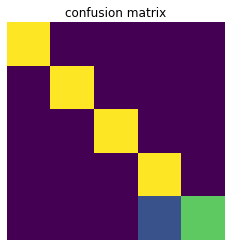

In [52]:
# confusion matrix
confusion_matrix = np.zeros((5,5))
for data in new_test_dataset:
    angle_list, true_class = data
    predict_class = classifier.predict([angle_list])[0]
    confusion_matrix[true_class, predict_class] +=1
print(confusion_matrix)

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)
ax.set_title("confusion matrix")
plt.axis("off")
plt.savefig("complex_confusion.png")
plt.show()

In [47]:
class HandGesture:
    def __init__(self):
        self.classifier = KNeighborsClassifier(n_neighbors=3)
        
        with open("new_training_dataset.pkl","rb") as f:
            dataset = pickle.load(f)
        training_inputs = []
        training_labels = []
        for data in dataset:
            angle_list, true_class = data
            training_inputs.append(angle_list)
            training_labels.append(true_class)
        self.classifier.fit(training_inputs, training_labels)
    
    def get_prediction(self, hand_landmarks):
        adjacency_list = [
            [0,1,2],[1,2,3],[2,3,4],[0,5,6],[5,6,7],[6,7,8],
            [0,9,10],[9,10,11],[10,11,12],[0,13,14],[13,14,15],
            [14,15,16],[0,17,18],[17,18,19],[18,19,20]
        ]

        angle_list=[]

        for adjacency in adjacency_list :
            idx0, idx1, idx2 = adjacency
            point0 = np.array([hand_landmarks.landmark[idx0].x, hand_landmarks.landmark[idx0].y, hand_landmarks.landmark[idx0].z])
            point1 = np.array([hand_landmarks.landmark[idx1].x, hand_landmarks.landmark[idx1].y, hand_landmarks.landmark[idx1].z])
            point2 = np.array([hand_landmarks.landmark[idx2].x, hand_landmarks.landmark[idx2].y, hand_landmarks.landmark[idx2].z])

            vector0 = point0 - point1
            vector1 = point2 - point1
            inner_product_result = np.dot(vector0,vector1)
            cos_theta = inner_product_result/(np.linalg.norm(vector0) * np.linalg.norm(vector1))
            theta = np.arccos(cos_theta)
            angle_list.append(theta)
            
        #predict_class = self.classifier.predict([angle_list])[0]
        predict_probs = self.classifier.predict_proba([angle_list])[0]
        
        predict_class = np.argmax(predict_probs)
        predict_prob = max(predict_probs)
        
        return predict_class, predict_prob
    
    def is_thumb_up(self, hand_landmarks):
        thumb_mcp_idx = 2
        thumb_tip_idx = 4
        thumb_mcp_y = hand_landmarks.landmark[thumb_mcp_idx].y
        thumb_tip_y = hand_landmarks.landmark[thumb_tip_idx].y
        finger_up = thumb_tip_y < thumb_mcp_y
        return finger_up
    
    def get_gesture(self, hand_landmarks):
        prediction, predict_prob = self.get_prediction(hand_landmarks)
        
        if predict_prob < 0.7:
            return "none"
        elif prediction == 0:
            return "one"
        elif prediction == 1:
            return "two"
        elif prediction == 2:
            return "three"
        elif prediction == 3:
            if self.is_thumb_up(hand_landmarks):
                return "thumb up"
            else:
                return "thumb down"
        elif prediction == 4:
            return "hand raise"
        
    def show_gesture(self, gesture):
        img_name = gesture.replace(' ', '_') + ".png"
        img = cv2.imread(f"img/{img_name}")
        cv2.imshow("emoji", img)

In [48]:
hand_gesture = HandGesture()

In [51]:
cap = cv2.VideoCapture(0)
hands = mp_hands.Hands(static_image_mode=False , max_num_hands = 1 , min_detection_confidence=0.7, min_tracking_confidence=0.5)

history_len = 10
gesture_history = ["none"]*history_len

while cap.isOpened():
    success, img = cap.read()
    if not success:
        print("read fail")
        continue
        
    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False
    results = hands.process(img)
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    if results.multi_hand_landmarks is not None:
        hand_landmarks = results.multi_hand_landmarks[0]
        mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        gesture = hand_gesture.get_gesture(hand_landmarks)
    else:
        gesture = "none"
        
    gesture_history.append(gesture)
    gesture_history = gesture_history[1:]
    max_gesture = "none"
    max_cnt = 0
    for gesture_name in ["one" , "two" , "three" , "thumb up" , "thumb down" , "hand raise" , "none"]:
        cnt = gesture_history.count(gesture_name)
        if max_cnt < cnt:
            max_cnt = cnt
            max_gesture = gesture_name
    gesture = max_gesture
    
    cv2.putText(img, gesture , org=(50,50), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale = 1, color = (0,0,255))
    hand_gesture.show_gesture(gesture)
    
    cv2.imshow("test" , img)
    if cv2.waitKey(5)==27:
        break
        
cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc